# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [1]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2022-09-19 00:56:55--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat’

notMNIST_small.mat  100%[===================>] 112.14M  2.49MB/s    in 69s     

2022-09-19 00:58:04 (1.64 MB/s) - ‘notMNIST_small.mat’ saved [117586976/117586976]



In [2]:
import matplotlib.pyplot as plt
from scipy import io # numpy보다 좀 더 범용적인 과학분야 계산 모듈 / 데이터를 불러오기 위해 사용
import numpy as np 
from sklearn.model_selection import train_test_split

## Data Loading

In [3]:
data = io.loadmat("notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1)) # 배열의 위치를 바꾸는 것

y = y.astype('int32') # 자료형 변환
X = X.astype('float32') / 255. # => MinMax 스케일링

# shape: (sample, x, y, channel)
X = X.reshape((-1, resolution, resolution, 1))

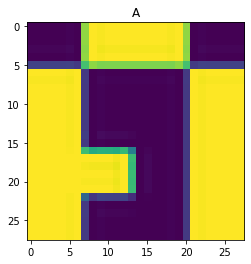

In [9]:
# looking at data; some fonts are strange
i = np.random.randint(0, 18724)

plt.imshow(X[i,:,:,0])
plt.title("ABCDEFGHIJ"[y[i]]);

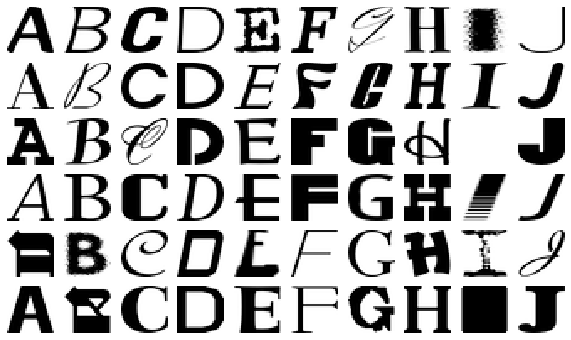

In [5]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [6]:
# splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [7]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979,))

In [18]:
# one-hot encoding
from tensorflow.keras.utils import to_categorical

class_n = len(np.unique(y_train))

y_train = to_categorical(y_train, class_n)
y_test = to_categorical(y_test, class_n)

In [21]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979, 10))

# Keras를 이용한 모델링 훈련!

1. Flatten layer 활용
2. Optimizer를 따로 선언해서 사용
3. Dropout을 0.2 정도로 활용해볼 것
4. 초기값은 default로
5. activation이 주어진 Dense layer뒤에 BatchNormalization둬볼 것
6. Early stopping도 활용해볼 것

In [10]:
# 모듈 import 
from tensorflow import keras

In [59]:
# 1. 세션 클리어
keras.backend.clear_session()

# 2. 사슬처럼 레이어 엮기
il = keras.layers.Input(shape=(28, 28, 1))
fl = keras.layers.Flatten()(il)
h1 = keras.layers.Dense(128, activation='relu')(fl)
b1 = keras.layers.BatchNormalization()(h1)
h2 = keras.layers.Dense(128, activation='relu')(b1)
b2 = keras.layers.BatchNormalization()(h2)
h3 = keras.layers.Dense(64, activation='relu')(b2)
b3 = keras.layers.BatchNormalization()(h3)
dl = keras.layers.Dropout(0.2)(b3)
ol = keras.layers.Dense(10, activation='softmax')(dl)

# 3. 모델 시작과 끝 연결
model = keras.models.Model(il, ol)

# 4. 모델 컴파일
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# 5. 모델 구조 살펴보기
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                             

In [55]:
# es 선언
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss',
                   min_delta=0,        # 설정 값 이상으로 개선되어야 개선 된 것으로 인정
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

In [56]:
mcp = ModelCheckpoint(filepath='/content/model.ckpt',
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True,            # 베스트 값만 저장
                      save_weights_only=False)         # 가중치만 저장

In [60]:
# 모델 학습
model.fit(x_train, y_train, epochs=1000, verbose=1, callbacks=[es, mcp], validation_split=0.15)

Epoch 1/1000
395/398 [============================>.] - ETA: 0s - loss: 0.6060 - accuracy: 0.8235
Epoch 1: val_loss did not improve from 0.36574
398/398 [==============================] - 3s 6ms/step - loss: 0.6053 - accuracy: 0.8238 - val_loss: 0.4212 - val_accuracy: 0.8798
Epoch 2/1000
388/398 [============================>.] - ETA: 0s - loss: 0.3807 - accuracy: 0.8882
Epoch 2: val_loss did not improve from 0.36574
398/398 [==============================] - 2s 5ms/step - loss: 0.3827 - accuracy: 0.8870 - val_loss: 0.4187 - val_accuracy: 0.8798
Epoch 3/1000
396/398 [============================>.] - ETA: 0s - loss: 0.3374 - accuracy: 0.9004
Epoch 3: val_loss did not improve from 0.36574
398/398 [==============================] - 2s 5ms/step - loss: 0.3372 - accuracy: 0.9005 - val_loss: 0.4007 - val_accuracy: 0.8865
Epoch 4/1000
392/398 [============================>.] - ETA: 0s - loss: 0.2944 - accuracy: 0.9127
Epoch 4: val_loss did not improve from 0.36574
398/398 [==================

In [58]:
from sklearn.metrics import accuracy_score

pred_test = model.predict(x_test)

single_pred_test = pred_test.argmax(axis=1)

logi_test_accuracy = accuracy_score(y_test.argmax(axis=1), single_pred_test)

print('테스트 정확도 : {:.2f}%'.format(logi_test_accuracy*100))

테스트 정확도 : 90.28%
